# Analysis of the Outer Solar System Orbits in Fourier Space
By: Ari Silburt

In this notebook I outline the steps to create numerous simulations with rebound and then do a basic Fourier analysis. Here I focus on the outer solar system, varying the masses using a "massfac" variable, which is a uniform multiplicative factor on masses of the bodies. As massfac is increased, the system becomes more and more unstable, and chaotic features in the fourier spectrum are seen. 

Note that for your own personalized simulations, the input/output paths may need to be modified...

In [2]:
import rebound
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Here we set up the outer solar system with the possibility to inflate the masses. Such a system is known to go unstable on short timescales (e.g. Chambers, 1999). The simulation stops once there is a close encounter. 

In [ ]:
def problem(mass_fac,output_N,tmax):
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.dt = 0.03*2*np.pi
    
    #add bodies
    m_jupiter = 9.543e-4
    a_jupiter = 5.2
    sim.add(m=1.)
    sim.add(a=a_jupiter,m=m_jupiter*mass_fac,e=0.01,inc=1e-4,f=np.random.random()*np.pi*2)
    sim.add(a=9.5,m=2.857e-4*mass_fac,e=0.005,inc=1e-3,f=np.random.random()*np.pi*2)
    sim.add(a=19.2,m=4.365e-5*mass_fac,e=0.01,inc=-2e-4,f=np.random.random()*np.pi*2)
    sim.add(a=30.1,m=5e-5*mass_fac,e=0.002,inc=-1e-3,f=np.random.random()*np.pi*2)
    sim.N_active = sim.N
    
    sim.move_to_com()
    E0 = sim.calculate_energy()
    sim.init_megno()
    print sim.N, sim.N_active, sim.N_var
    
    #condition to stop the simulation
    sim.exit_min_distance = a_jupiter*(m_jupiter/3.)**(1./3.)
    sim.exit_max_distance = 50.
    
    #integrate and output
    output_name = "Fourier/outerSS_t"+str('{0:.1e}'.format(tmax))+"_massfac"+str(mass_fac)+".csv"
    times = np.linspace(0,tmax*2*np.pi,output_N)
    print 'starting simulation for '+output_name
    with open(output_name, 'w') as f:
        try:
            for t in times:
                sim.integrate(t)
                f.write(str(sim.t/(2*np.pi)))
                #f.write(','+str(sim.calculate_lyapunov()))
                outs = []
                for p in sim.particles[1:sim.N - sim.N_var]:
                    outs += [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]
                for out in outs:
                    f.write(',{0}'.format(out))
                f.write('\n')
            print 'Simulation '+output_name+' complete. Final energy error is:', abs((E0 - sim.calculate_energy())/E0)
        except rebound.Encounter as error:
            print "Close encounter, simulation "+output_name+" stopping."
            f.write(str(sim.t/(2*np.pi)))
            #f.write(','+str(sim.calculate_lyapunov()))
            outs = []
            for p in sim.particles[1:sim.N - sim.N_var]:
                outs += [p.a, p.P, p.e, p.pomega, p.inc, p.Omega, p.f]
            outs += []
            for out in outs:
                f.write(',{0}'.format(out))
            f.write('\n')

Choose the parameters you will search over.

In [ ]:
n_runs = 20        #number of simulations you want to run
max_mass_fac = 50  #upper limit of the mass fac range (lower limit is 1, i.e. no inflated masses)
n_outputs = 10000  #number of outputted data points, important for FFT
tmax = 1e6         #simulation time

**Warning!** Executing the code below will take a long time!

In [ ]:
#Get inputs
mass_fac = np.round(np.logspace(0,np.log10(max_mass_fac),n_runs),2)       #inflated mass factor of planets
params = zip(mass_fac,np.ones(n_runs)*n_outputs,np.ones(n_runs)*tmax)

#Run the problem
import multiprocessing as mp
def execute(pars):
    problem(pars[0],pars[1],pars[2])

if __name__== '__main__':
    pool = mp.Pool(processes=n_runs)
    pool.map(execute, params)
    pool.close()
    pool.join()

# Functions
Here are the functions we need to create to do a Fourier analysis

In [3]:
#extra variables that we might want to plot
def get_var(data,i,var):
    if var == "LCE":
        return data["LCE"]
    if var == "z":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.exp(pomega*1j)
    if var == "h":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.cos(pomega)
    if var == "k":
        e = data["e"+i].values
        pomega = data["pomega"+i].values
        return e*np.sin(pomega)
    else:
        return data[var+i].values

In [4]:
def plot_eigenfreqSS(min_power):
    arc2rad = 4.8481e-6
    eigenfreq = [5.462,7.346,17.33,18.00,3.724,22.44,2.708,0.6345]
    outereigenfreq = [3.724,22.44,2.708,0.6345]
    #eigenfreq2 = [5.46326,7.34474,17.32832,18.00233,4.29591,27.77406,0.271931,0.63332,-19.18225,51.25222]
    freq = 2*np.pi/(np.asarray(outereigenfreq)*arc2rad)
    
    names=['SS Eigenfreqs','','','','','','','','','']
    for i,f in enumerate(freq):
        plt.plot([f,f],[0.0035,-0.0035],'k--',label=names[i])

In [50]:
#1-D frequency map
import scipy.signal as signal
def fourier(data,var,tmax,N_outputs,output_name):        
    lomb_analysis = 1
    
    t=data["Time"].values
    window = np.hanning(N_outputs)
    if lomb_analysis == 1:
        N_freq = 1000
        Period = np.logspace(np.log10(tmax/N_outputs/(2*np.pi)),np.log10(tmax/(2*np.pi)),N_freq).astype('float64')
    else:
        freq = np.fft.fftfreq(N_outputs, tmax/N_outputs)
    plt.figure(figsize=(12,8))
    names = ['Jupiter','Saturn','Uranus','Neptune']
    for i,num in enumerate(['1', '2', '3', '4']):
        plt.subplot(2, 1, 1)
        y = get_var(data,num,var)
        if lomb_analysis == 1:
            power = signal.lombscargle(t,np.absolute(y)*window,1./Period) #angular frequencies passed!
            plt.plot(2*np.pi*Period, np.sqrt(4*power/N_outputs), label=names[i])
        else:
            power = np.absolute(np.fft.fft(y)/N_outputs)
            plt.plot(1./freq,power,label=names[i])
        plt.subplot(2, 1, 2)
        plt.plot(t,y,label=num)

    plt.subplots_adjust(hspace=0.4)
    plt.subplot(2, 1, 1)
    plot_eigenfreqSS(min(power))
    plt.ylabel("power of: "+var)
    plt.legend(loc="upper left")
    plt.xlabel('frequencies')
    plt.xscale('log')
    plt.subplot(2, 1, 2)
    plt.ylabel(var)
    plt.xlabel('time')
    if var == "LCE":
        plt.yscale('log')
    out = output_name.split(".csv")[0].split("data")[1]
    plt.savefig("Fourier/images/"+out+"_fft-"+var+".png")

# Analyze single

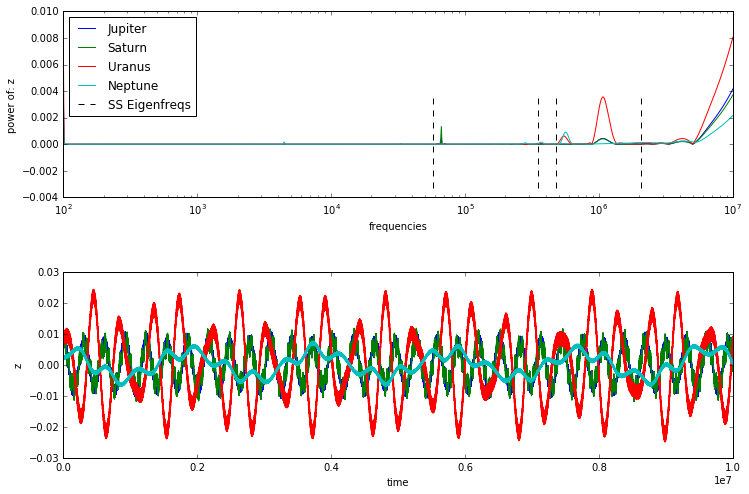

In [51]:
%matplotlib inline
f = "Fourier/data/SS_1e7/outerSS_t1.0e+07_massfac1.0.csv"
var = "z"  
columns = ['Time']
for i in ['1', '2', '3', '4']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]
    
data = pd.read_csv(f,header=None,names=columns)
data.head()
tmax = float(f.split("_")[-2].split("t")[1])
N_outputs = len(data.index)
fourier(data,var,tmax,N_outputs,f)

# Analyze Batch
Let's batch analyze our data now (note you may have to change the file_location variable).

In [ ]:
#If just wanting to batch analyze .csv files
file_location = 'Fourier/data/SS_1e7/*.csv'  #Location of where data is stored. 
var = "z"                        #choices are h,k,z or any of the orbital elements (e.g. a,P,e,pomega,etc.)

In [ ]:
import glob
files = glob.glob(file_location)
columns = ['Time']
for i in ['1', '2', '3', '4']:
    columns += ['a'+i, 'P'+i, 'e'+i, 'pomega'+i, 'inc'+i, 'Omega'+i, 'f'+i]

for f in files:
    data = pd.read_csv(f,header=None,names=columns)
    tmax = float(f.split("_")[-2].split("t")[1])
    N_outputs = len(data.index)
    fourier(data,var,tmax,N_outputs,f)

# Play with FFT on basic sine function
If you want to get a grasp of what the FFT is doing, here is the basic vanilla FFT that you can play with on a sine function. You can also play with the Lomb-Scargle periodogram, which does the same thing as an FFT except doesn't require evenly spaced points.

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


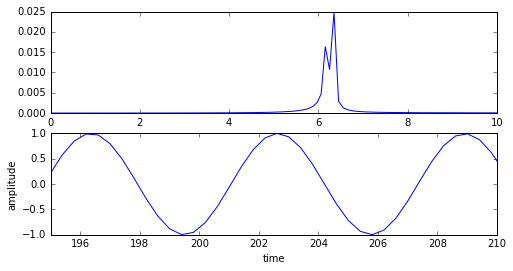

In [7]:
%matplotlib inline
#import scipy.signal as signal
Npts = 1000
period = 1
t_min=0.
t_max=400.

lomb = 0
plt.figure(figsize=(8,4))
plt.subplot(2, 1, 1)

t = np.linspace(t_min,t_max,Npts).astype('float64')
window = np.hanning(Npts)
y = np.sin(period*t).astype('float64')*window

if lomb == 1:
    freq = np.linspace(0.1,10,100).astype('float64')/(2*np.pi)
    power = signal.lombscargle(t,y*window,freq)
    plt.plot(2*np.pi/freq, np.sqrt(4*power/Npts))
else:
    power = np.fft.fft(y)/Npts
    freq = np.fft.fftfreq(Npts, t_max/Npts)
    plt.plot(1./freq, np.sqrt(4*power/Npts))


plt.xlim([0,10])
plt.subplot(2, 1, 2)
plt.plot(t,y)
plt.xlim([195,210])
plt.xlabel("time")
plt.ylabel("amplitude")